In [54]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
#import plotly.plotly as py
#from plotly import tools

from ipywidgets import widgets
from IPython.display import display
#from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
#init_notebook_mode(connected=True)

In [55]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

def quantileNormalize(df_input, keep_na=True):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        norm = [rank[i] for i in t]
        if keep_na == True:
            norm = [np.nan if np.isnan(a) else b for a,b in zip(df[col],norm)]
        df[col] =  norm             
    return df

In [56]:
#add back the description of the proteins
desc_dict = {}
path = '../PIG-A/TriTrypDB-46_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [57]:
df = pd.read_csv('txt/proteinGroups.txt',sep='\t')
df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)
df.head()


removed  11 Only identified by site
tot  11  entries removed
---------------
removed  7 Reverse
tot  18  entries removed
---------------
removed  35 Potential contaminant
tot  53  entries removed
---------------


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,DSSTP_K site IDs,Oxidation (M) site IDs,DSSTP_K site positions,Oxidation (M) site positions,Gene_desc
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4480,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,22;22,22;22,22;22,Tb927.5.4480:mRNA-p1 | transcript=Tb927.5.4480...,2,22,22,22,...,True;True;True;True;True;True;True;True;True;T...,323;435;436;980;1053;1148;1211;1985;2361;2616;...,609;610;611;849;850;1792;1918;1919;2076;2182;2...,645;646;881;882;1830;1949;1950;2093;2190;3621;...,645;882;1830;1949;2093;2190;3621;4366;4822;492...,NaN,37;38;39;40;41,NaN,176;207;283;324;579,"paraflagellar rod component par4, putative"
Tb927.5.4380,Tb927.5.4380:mRNA-p1;Tb05.5K5.30:mRNA-p1,Tb927.5.4380:mRNA-p1;Tb05.5K5.30:mRNA-p1,3;3,3;3,3;3,Tb927.5.4380:mRNA-p1 | transcript=Tb927.5.4380...,2,3,3,3,...,True;True;True,427;1931;3508,835;3491;3492;3493;3494;6430,865;3512;3513;6575,865;3513;6575,NaN,42,NaN,543,Kinetoplastid-specific Protein Phosphatase 1
Tb09.v4.0067,Tb09.v4.0067:pseudogenic_transcript-p1,Tb09.v4.0067:pseudogenic_transcript-p1,2,1,1,Tb09.v4.0067:pseudogenic_transcript-p1 | trans...,1,2,1,1,...,True;False,2737;4201,4951;7706,5004;8045,5004;8045,NaN,43,NaN,521,"retrotransposon hot spot protein, pseudogene"
Tb927.10.4490,Tb927.10.4490:mRNA-p1;Tb10.v4.0039:mRNA-p1,Tb927.10.4490:mRNA-p1;Tb10.v4.0039:mRNA-p1,1;1,1;1,1;1,Tb927.10.4490:mRNA-p1 | transcript=Tb927.10.44...,2,1,1,1,...,True,2162,3961,3973,3973,NaN,NaN,NaN,NaN,"hypothetical protein, conserved"
Tb10.v4.0052,Tb10.v4.0052:mRNA-p1;Tb927.10.10360:mRNA-p1;Tb...,Tb10.v4.0052:mRNA-p1;Tb927.10.10360:mRNA-p1;Tb...,14;11;11,2;2;2,2;2;2,Tb10.v4.0052:mRNA-p1 | transcript=Tb10.v4.0052...,3,14,2,2,...,False;False;False;False;False;False;False;Fals...,762;763;764;874;876;1722;1723;1724;3105;3106;3...,1415;1416;1417;1418;1419;1420;1421;1422;1423;1...,1448;1449;1450;1451;1452;1453;1454;1455;1456;1...,1449;1459;1463;1626;1629;3096;3102;5738;5856;5...,NaN,44;45;46;47,NaN,17;169;4824;4861,microtubule-associated protein 2


In [58]:
df['Intensity 1']=df['Intensity 1']+df['Intensity 1'][df['Intensity 1']>0].min()
df['Intensity 2']=df['Intensity 2']+df['Intensity 2'][df['Intensity 2']>0].min()

df['iBAQ 1']=df['iBAQ 1']+df['iBAQ 1'][df['iBAQ 1']>0].min()
df['iBAQ 2']=df['iBAQ 2']+df['iBAQ 2'][df['iBAQ 2']>0].min()

df['LFQ intensity 1']=df['LFQ intensity 1']+df['LFQ intensity 1'][df['LFQ intensity 1']>0].min()
df['LFQ intensity 2']=df['LFQ intensity 2']+df['LFQ intensity 2'][df['LFQ intensity 2']>0].min()

In [59]:
#np.log2(df[['Intensity 1','Intensity 2','iBAQ 1','iBAQ 2', 'LFQ intensity 1', 'LFQ intensity 2']]).plot(kind='box')

In [60]:
df['fc1']= df['Intensity 1']/df['Intensity 2']
df['fc2']= df['iBAQ 1']/df['iBAQ 2']
df['fc3']= df['LFQ intensity 1']/df['LFQ intensity 2']

df['log10_score'] = np.log10(df['Score'])
df['log10_intensity'] = np.log10(df['Intensity'])
df['log10_iBAQ'] = np.log10(df['iBAQ'])

df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1']].sort_values(['fc1','log10_intensity'], ascending=False).head(5)

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1
Gene_id,,,,,,,,
Tb11.v5.0765,N-acetylglucosaminyl-phosphatidylinositol bios...,280.478761,2501.404342,1266.184543,0.738891,7.727858,6.497413,53616320
Tb927.9.14280,"hypothetical protein, conserved",87.279347,167.951733,376.384203,0.753568,7.217668,5.320042,16684320
Tb927.5.1210,"short-chain dehydrogenase, putative",47.935865,422.118400,235.301811,0.510237,6.953571,5.723119,9163420
Tb927.3.4570,"N-acetylglucosamyl transferase component GPI1,...",20.059741,95.615538,96.120570,0.419344,6.563161,5.071808,3834620
Tb927.5.3600,"ATP-dependent DEAD/H RNA helicase, putative",17.358339,53.834367,86.230460,0.590652,6.497054,4.815817,3318220


In [61]:
#np.log2(df[['Intensity 1','Intensity 2','iBAQ 1','iBAQ 2', 'LFQ intensity 1', 'LFQ intensity 2']]).plot(kind='box')

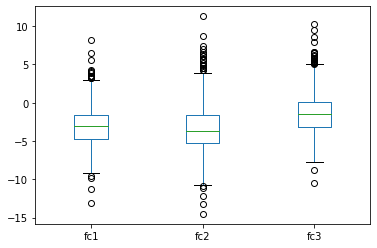

In [62]:
np.log2(df[['fc1','fc2','fc3']]).plot(kind='box')

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1
Gene_id,,,,,,,,
Tb11.v5.0765,N-acetylglucosaminyl-phosphatidylinositol bios...,1349.355882,1349.355882,1349.355882,0.738891,7.727858,6.497413,53616320
Tb927.9.14280,"hypothetical protein, conserved",406.638318,197.423934,197.423934,0.753568,7.217668,5.320042,16684320
Tb927.5.1210,"short-chain dehydrogenase, putative",197.423934,406.638318,127.382524,0.510237,6.953571,5.723119,9163420
Tb927.3.4570,"N-acetylglucosamyl transferase component GPI1,...",127.382524,71.502135,64.169600,0.419344,6.563161,5.071808,3834620
Tb927.5.3600,"ATP-dependent DEAD/H RNA helicase, putative",71.502135,47.391542,54.574470,0.590652,6.497054,4.815817,3318220
Tb927.4.1250,"peroxisome biogenesis factor 1, putative",64.169600,38.248464,47.391542,0.366124,6.454860,4.755890,3027420
Tb927.4.590,PQQ-like domain/Protein of unknown function (D...,57.728278,44.457467,44.457467,0.032296,6.402089,4.800022,2701320
Tb927.7.5290,"hypothetical protein, conserved",54.574470,37.267369,38.248464,0.096458,6.301225,4.744919,2178220
Tb927.8.1950,"hypothetical protein, conserved",47.391542,39.682433,33.149328,0.667079,6.288585,4.770071,2120820


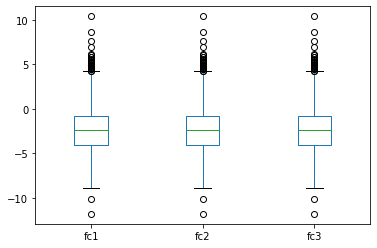

In [63]:
df[['fc1','fc2','fc3']]=quantileNormalize(df[['fc1','fc2','fc3']])
np.log2(df[['fc1','fc2','fc3']]).plot(kind='box')
df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1']].sort_values(['fc1','log10_intensity'], ascending=False).head(10)


In [64]:
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
onesample_results = ttest_ind(df[['fc1','fc2','fc2']].T, 
                              np.ones((3,df.shape[0])))
df['pvalues']=onesample_results.pvalue
df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1','pvalues']].sort_values(['fc1', 'log10_intensity'], ascending=False).head(10)

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1,pvalues
Gene_id,,,,,,,,,
Tb11.v5.0765,N-acetylglucosaminyl-phosphatidylinositol bios...,1349.355882,1349.355882,1349.355882,0.738891,7.727858,6.497413,53616320,0.000000
Tb927.9.14280,"hypothetical protein, conserved",406.638318,197.423934,197.423934,0.753568,7.217668,5.320042,16684320,0.018833
Tb927.5.1210,"short-chain dehydrogenase, putative",197.423934,406.638318,127.382524,0.510237,6.953571,5.723119,9163420,0.008544
Tb927.3.4570,"N-acetylglucosamyl transferase component GPI1,...",127.382524,71.502135,64.169600,0.419344,6.563161,5.071808,3834620,0.008744
Tb927.5.3600,"ATP-dependent DEAD/H RNA helicase, putative",71.502135,47.391542,54.574470,0.590652,6.497054,4.815817,3318220,0.002481
Tb927.4.1250,"peroxisome biogenesis factor 1, putative",64.169600,38.248464,47.391542,0.366124,6.454860,4.755890,3027420,0.006042
Tb927.4.590,PQQ-like domain/Protein of unknown function (D...,57.728278,44.457467,44.457467,0.032296,6.402089,4.800022,2701320,0.000413
Tb927.7.5290,"hypothetical protein, conserved",54.574470,37.267369,38.248464,0.096458,6.301225,4.744919,2178220,0.001885
Tb927.8.1950,"hypothetical protein, conserved",47.391542,39.682433,33.149328,0.667079,6.288585,4.770071,2120820,0.000088


In [65]:
df['mean']=df[['fc1','fc2','fc2']].mean(axis=1)

In [66]:
df['log_mean']=np.log2(df['mean'])
df['log_pvalues']=-np.log10(df['pvalues']+0.0001)
df['pvalues']=onesample_results.pvalue
df[['Gene_desc',
     'log_pvalues',
    'log_mean',
   'log10_intensity']].sort_values(['log_mean',
                              'log_pvalues'], ascending=False).head(20)

,Gene_desc,log_pvalues,log_mean,log10_intensity
Gene_id,,,,
Tb11.v5.0765,N-acetylglucosaminyl-phosphatidylinositol bios...,4.000000,10.398055,7.727858
Tb927.5.1210,"short-chain dehydrogenase, putative",2.063276,8.396177,6.953571
Tb927.9.14280,"hypothetical protein, conserved",1.722775,8.061571,7.217668
Tb927.10.6140,phosphatidylinositolN- acetylglucosaminyltrans...,1.503529,6.609861,6.275565
Tb927.3.4570,"N-acetylglucosamyl transferase component GPI1,...",2.053372,6.493918,6.563161
Tb927.5.3600,"ATP-dependent DEAD/H RNA helicase, putative",2.588271,5.792554,6.497054
Tb927.10.4610,"dolicholphosphate-mannose synthase, putative",2.411272,5.786654,6.226239
Tb927.5.5420,"Variant Surface Glycoprotein, putative",2.926654,5.692455,6.279347
Tb927.4.1540,"NAD dependent epimerase/dehydratase family, pu...",3.660379,5.678132,6.287936


In [67]:
from adjustText import adjust_text

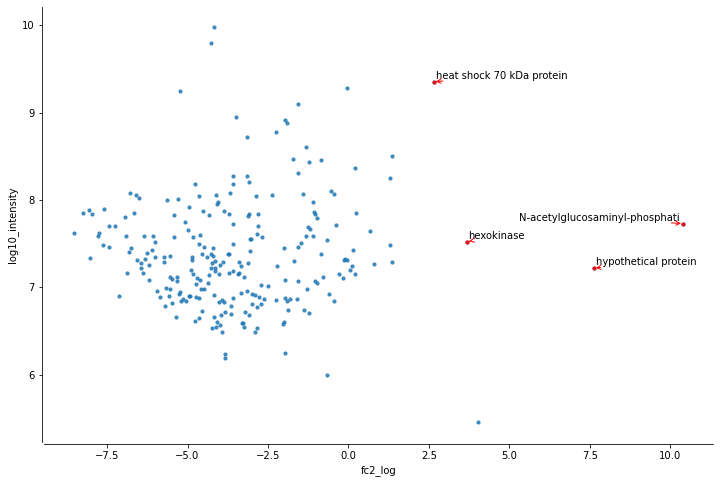

In [77]:
df['fc2_log']=np.log2(df['fc2'])
df['log10_score']=np.log2(df['Score'])

selection = df[df['Score']>5]
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='fc2_log', y='log10_intensity', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=2, trim=False)


select = df[(df['fc2_log']>2)&(df['log10_intensity']>6.5)&(df['Score']>5)]
#select.plot(x='log_mean', y='log10_intensity',kind='scatter', c='r', ax=ax)



sns.regplot(x='fc2_log', y='log10_intensity', 
            fit_reg=False, data = select,
            ax=ax, scatter_kws={'s':10,'color':'red'})


texts = [plt.text(select.loc[i]['fc2_log'], 
                  select.loc[i]['log10_intensity'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30]
                 ) for i in select.index.values]

adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))



#x = selection.loc[['Tb927.11.12080']]['log_mean']
#y= selection.loc[['Tb927.11.12080']]['log10_intensity']
#ax.annotate('Bait',(x,y), xytext=(x+0.01,y))

#x = selection.loc[['Tb927.10.9860']]['fc']
#y= selection.loc[['Tb927.10.9860']]['log10_score']
#ax.annotate('MTQ1, putative',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.11.15990']]['fc']
#y= selection.loc[['Tb927.11.15990']]['log10_score']
#ax.annotate('NUP109',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.10.7100']]['fc']
#y= selection.loc[['Tb927.10.7100']]['log10_score']
#ax.annotate('Tb927.10.7100',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.11.12500']]['fc']
#y= selection.loc[['Tb927.11.12500']]['log10_score']
#ax.annotate('Tb927.11.12500',(x,y),xytext=(x+0.01,y))




#ax.set_xlabel('Sum Intensity / Bait Intensity')
#ax.set_ylabel('Log10 Score')
plt.savefig('Fig1.svg')
plt.savefig('Fig1.png')
plt.show()

In [78]:
df.loc['Tb11.v5.0765'][['fc2_log','log10_intensity','Gene_desc','Score']]

fc2_log                                                      10.3981
log10_intensity                                              7.72786
Gene_desc          N-acetylglucosaminyl-phosphatidylinositol bios...
Score                                                         5.4814
Name: Tb11.v5.0765, dtype: object

In [75]:
df[['fc2_log','log10_intensity','Gene_desc','Score']].to_csv('table_1.csv')

In [41]:
#list(select.columns)

In [44]:
for n in select.index.values:
    print(n,select.loc[n]['fc2_log'],select.loc[n]['Gene_desc'])

Tb11.v5.0732 3.6885568317961446 hexokinase, putative
Tb11.v5.0765 10.39805518260526 N-acetylglucosaminyl-phosphatidylinositol biosynthetic protein, putative
Tb927.3.4570 6.159914412525503 N-acetylglucosamyl transferase component GPI1, putative
Tb927.5.1210 8.667602357088795 short-chain dehydrogenase, putative
Tb927.6.3800 2.6496229806254026 heat shock 70 kDa protein, mitochondrial precursor, putative
Tb927.9.14280 7.625153088689615 hypothetical protein, conserved
Tb927.9.15460 2.671914158731177 calcium motive p-type ATPase, putative


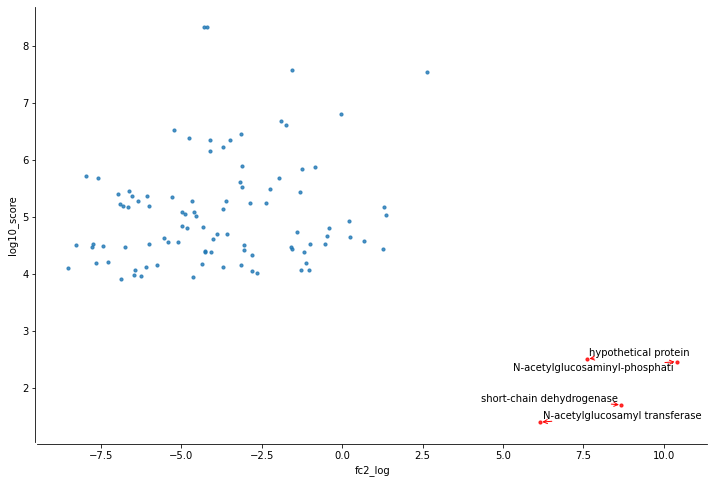

In [30]:
df['fc2_log']=np.log2(df['fc2'])
df['log10_score']=np.log2(df['Score'])

selection = df[df['Score']>15]
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='fc2_log', y='log10_score', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=2, trim=False)


select = df[(df['fc2_log']>5)&(df['log10_intensity']>6.5)]
#select.plot(x='log_mean', y='log10_intensity',kind='scatter', c='r', ax=ax)



sns.regplot(x='fc2_log', y='log10_score', 
            fit_reg=False, data = select,
            ax=ax, scatter_kws={'s':10,'color':'red'})


texts = [plt.text(select.loc[i]['fc2_log'], 
                  select.loc[i]['log10_score'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30]
                 ) for i in select.index.values]

adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))



#x = selection.loc[['Tb927.11.12080']]['log_mean']
#y= selection.loc[['Tb927.11.12080']]['log10_intensity']
#ax.annotate('Bait',(x,y), xytext=(x+0.01,y))

#x = selection.loc[['Tb927.10.9860']]['fc']
#y= selection.loc[['Tb927.10.9860']]['log10_score']
#ax.annotate('MTQ1, putative',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.11.15990']]['fc']
#y= selection.loc[['Tb927.11.15990']]['log10_score']
#ax.annotate('NUP109',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.10.7100']]['fc']
#y= selection.loc[['Tb927.10.7100']]['log10_score']
#ax.annotate('Tb927.10.7100',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.11.12500']]['fc']
#y= selection.loc[['Tb927.11.12500']]['log10_score']
#ax.annotate('Tb927.11.12500',(x,y),xytext=(x+0.01,y))




#ax.set_xlabel('Sum Intensity / Bait Intensity')
#ax.set_ylabel('Log10 Score')
plt.savefig('Fig2.svg')
plt.savefig('Fig2.png')
plt.show()

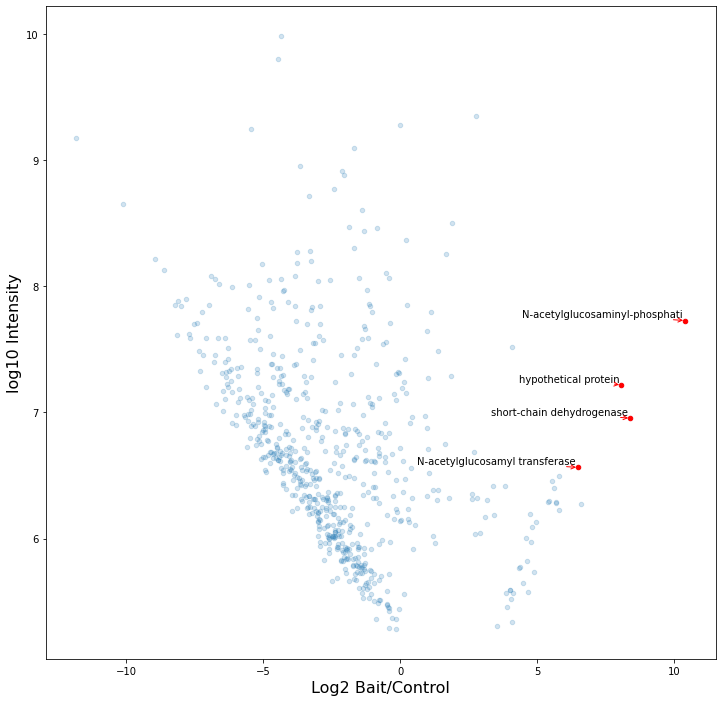

In [19]:
fig,ax=plt.subplots(figsize=(12,12))
df.plot(x='log_mean', y='log10_intensity',kind='scatter', ax=ax,alpha=0.2)

select = df[(df['log_mean']>5)&(df['log10_intensity']>6.5)]
select.plot(x='log_mean', y='log10_intensity',kind='scatter', c='r', ax=ax)

texts = [plt.text(select.loc[i]['log_mean'], 
                  select.loc[i]['log10_intensity'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30]
                 ) for i in select.index.values]

adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))
plt.xlabel('Log2 Bait/Control',size=16)
plt.ylabel('log10 Intensity',size=16)

plt.show()

In [75]:
df.plot(x='log_mean', y='log10_intensity',kind='scatter', ax=ax,alpha=0.2)

#interactive plot
trace_1 = go.Scatter(
    x=df.log_mean,
    y=df.log10_intensity,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b+ ' '+str(round(c,1)) for a,b,c in zip(df.index.values, df.Gene_desc, df.Score)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log(df.Score), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)


annot_1 = go.Scatter(
    x=[df.log_mean.loc['Tb11.v5.0765']],
    y=[df.log10_intensity.loc['Tb11.v5.0765']],
    mode='markers+text',
    name='Tb11.v5.0765',
    text=['Bait'],
    textposition='bottom center'
)
'''
annot_2 = go.Scatter(
    x=[temp.log2_ibaq_DEAC2.loc['Tb927.7.1220']],
    y=[temp.log10_int.loc['Tb927.7.1220']],
    mode='markers+text',
    name='Tb927.7.1220',
    text=['interesting'],
    textposition='bottom center'
)
'''

layout = dict(title='vulcano')

fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [ ]:
df.to_csv('data.csv')

In [46]:
df = pd.read_csv('txt/proteinGroups.txt',sep='\t')
df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)

df['signal_perc']    =  df['Intensity 1'] / (df['Intensity 1']+df['Intensity 2'])
df.head()

removed  11 Only identified by site
tot  11  entries removed
---------------
removed  7 Reverse
tot  18  entries removed
---------------
removed  35 Potential contaminant
tot  53  entries removed
---------------


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,DSSTP_K site IDs,Oxidation (M) site IDs,DSSTP_K site positions,Oxidation (M) site positions,Gene_desc,signal_perc
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4480,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,22;22,22;22,22;22,Tb927.5.4480:mRNA-p1 | transcript=Tb927.5.4480...,2,22,22,22,...,323;435;436;980;1053;1148;1211;1985;2361;2616;...,609;610;611;849;850;1792;1918;1919;2076;2182;2...,645;646;881;882;1830;1949;1950;2093;2190;3621;...,645;882;1830;1949;2093;2190;3621;4366;4822;492...,NaN,37;38;39;40;41,NaN,176;207;283;324;579,"paraflagellar rod component par4, putative",0.004121
Tb927.5.4380,Tb927.5.4380:mRNA-p1;Tb05.5K5.30:mRNA-p1,Tb927.5.4380:mRNA-p1;Tb05.5K5.30:mRNA-p1,3;3,3;3,3;3,Tb927.5.4380:mRNA-p1 | transcript=Tb927.5.4380...,2,3,3,3,...,427;1931;3508,835;3491;3492;3493;3494;6430,865;3512;3513;6575,865;3513;6575,NaN,42,NaN,543,Kinetoplastid-specific Protein Phosphatase 1,0.000000
Tb09.v4.0067,Tb09.v4.0067:pseudogenic_transcript-p1,Tb09.v4.0067:pseudogenic_transcript-p1,2,1,1,Tb09.v4.0067:pseudogenic_transcript-p1 | trans...,1,2,1,1,...,2737;4201,4951;7706,5004;8045,5004;8045,NaN,43,NaN,521,"retrotransposon hot spot protein, pseudogene",0.000000
Tb927.10.4490,Tb927.10.4490:mRNA-p1;Tb10.v4.0039:mRNA-p1,Tb927.10.4490:mRNA-p1;Tb10.v4.0039:mRNA-p1,1;1,1;1,1;1,Tb927.10.4490:mRNA-p1 | transcript=Tb927.10.44...,2,1,1,1,...,2162,3961,3973,3973,NaN,NaN,NaN,NaN,"hypothetical protein, conserved",NaN
Tb10.v4.0052,Tb10.v4.0052:mRNA-p1;Tb927.10.10360:mRNA-p1;Tb...,Tb10.v4.0052:mRNA-p1;Tb927.10.10360:mRNA-p1;Tb...,14;11;11,2;2;2,2;2;2,Tb10.v4.0052:mRNA-p1 | transcript=Tb10.v4.0052...,3,14,2,2,...,762;763;764;874;876;1722;1723;1724;3105;3106;3...,1415;1416;1417;1418;1419;1420;1421;1422;1423;1...,1448;1449;1450;1451;1452;1453;1454;1455;1456;1...,1449;1459;1463;1626;1629;3096;3102;5738;5856;5...,NaN,44;45;46;47,NaN,17;169;4824;4861,microtubule-associated protein 2,0.000000


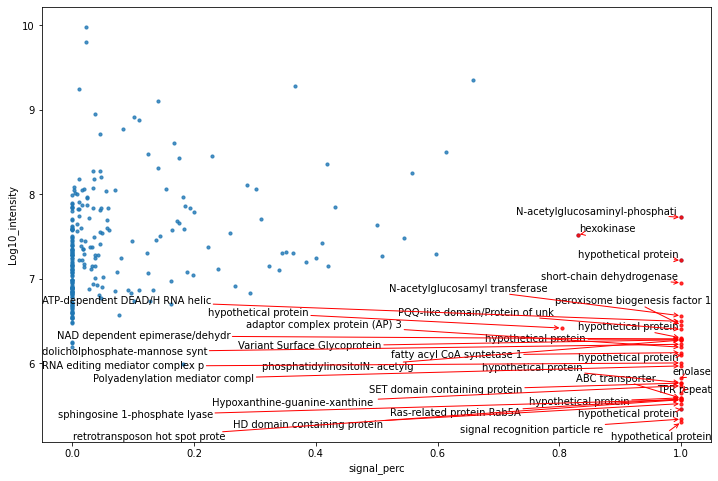

In [53]:
df['Log10_score']=np.log10(df['Score'])
df['Log10_intensity']=np.log10(df['Intensity'])
temp = df.copy()
temp = temp[temp['Score']>5]
#temp = temp[temp['Razor + unique peptides']>2]

fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='signal_perc', y='Log10_intensity',
            fit_reg=False, data = temp,##[df['exp_lf']>0.8],
            ax=ax, scatter_kws={'s':10})
#sns.despine(offset=10, trim=True)

#x_val = temp.loc['Tb927.3.2610']['signal_perc']
#y_val = temp.loc['Tb927.3.2610']['Log10_score']
#ax.scatter(x_val,y_val, s=35, c='r')
#ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.01, y_val),
#            )

#x_val = temp.loc['Tb927.11.11750']['signal_perc']
#y_val = temp.loc['Tb927.11.11750']['Log10_score']
#ax.scatter(x_val,y_val, s=35, c='r')
#ax.annotate('Tb927.11.11750', xy=(x_val, y_val), xytext=(x_val+0.01, y_val),
            #)
    
    
select = df[(df['signal_perc']>0.8)]
#select.plot(x='log_mean', y='log10_intensity',kind='scatter', c='r', ax=ax)



sns.regplot(x='signal_perc', y='Log10_intensity', 
            fit_reg=False, data = select,
            ax=ax, scatter_kws={'s':10,'color':'red'})


texts = [plt.text(select.loc[i]['signal_perc'], 
                  select.loc[i]['Log10_intensity'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30]
                 ) for i in select.index.values]

adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))
    
    
plt.savefig('Plot_1a.svg')
plt.savefig('Plot_1a.png')